## Exercise 3

Group: 2216

We chose to skip the creation of new data and used the data generated during class.

In [59]:
#Import necessary packages

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers, initializers
import tensorflow.random as tf_r

tf_r.set_seed(12345)
np.random.seed(12345)
input_shape = (60, 1)
n_class = 3

In [33]:
#Defining functions

def create_model(NCONV = 1,NF = 5,reg_type = 1,reg_lambda = 0.5):

    ## from keras import regularizers, initializers
    if reg_type == 1:
        reg = tf.keras.regularizers.l1(reg_lambda)
    
    elif reg_type == 2:
        reg = tf.keras.regularizers.l2(reg_lambda) ## raised to 0.2
        
    elif reg_type == 3:
        reg = tf.keras.regularizers.l1_l2(reg_lambda, reg_lambda)
    
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                            seed=None)
    
    # challenge: at most 600 tunable parameters
    model = Sequential()
    # 
    if NCONV==1:
        # -----2-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg,
                        activation='relu', 
                        input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7, 
                        activation='relu',kernel_regularizer=reg))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))
    # 

    if NCONV==2:
        # -----1-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg, ######## TRY WITHOUT !
                        activation='relu', input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(9, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(6, activation='relu'))
        model.add(Dropout(0.2))
        #model.add(Dense(10, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(n_class, activation='softmax')) # softmax !
    opt = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=opt,metrics=['accuracy'])
    
    return model


def load_data(filename, perc_train = 0.8):
    str0 = filename
    fnamex='DATA_1/x_'+str0
    fnamey='DATA_1/y_'+str0
    
    #fnamex='DATA/x_'+str0
    #fnamey='DATA/y_'+str0
    
    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])


    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1
    # print('data: ',N)

    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1.

    # rescaling stuff
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    
    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)

    
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)

    return x_train,y_train,x_val,y_val

def Show_data(x,L,s="data"):
    plt.plot(np.arange(L),x[0])
    plt.plot(np.arange(L,2*L),x[1])
    plt.plot(np.arange(2*L,3*L),x[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()

    
def Show_weights(model,ax1,ax2,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    ax1.axhline(0, c="k")
    ax1.plot((0,))
    for i in range(M):
        ax1.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax1.set_title(label+': filters of layer '+str(l))
    ax1.set_xlabel('index')
    
    ax2.axhline(0, c="k")
    for i in range(M):
        ax2.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax2.set_title(label+': bias of layer '+str(l))
    ax2.set_xlabel('filter nr')
    ax2.set_xticks(np.arange(5))
    ax2.legend()
    
def Show_history(fit,ax1,ax2):
    ax1.plot(fit.history['accuracy'],"b",label="train")
    ax1.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax1.plot((0,len(fit.history['val_accuracy'])),(1/3,1/3),":",c="gray",label="random choice")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.legend()
    
    ax2.plot(fit.history['loss'],"b",label="train")
    ax2.plot(fit.history['val_loss'],"r--",label="valid.")
    ax2.set_xlabel('epoch')
    ax2.set_ylabel("Loss")
    ax2.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax2.legend()

def Show_history_single(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model",axis = None):

    if axis == None:
        matrix = metrics.confusion_matrix(validations, predictions)
        plt.figure(figsize=(6, 5))
        seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
        plt.title(label+': Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    else:
        matrix = metrics.confusion_matrix(validations, predictions)
        seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap,
                    ax = axis)
        axis.set_title(label+': Confusion Matrix')
        axis.set_ylabel('True Label')
        axis.set_xlabel('Predicted Label')

A :50, Final validation accuracy 0.3434999883174896  validation loss 1.1016194820404053
A :100, Final validation accuracy 0.34700000286102295  validation loss 1.0979558229446411
A :250, Final validation accuracy 0.6704999804496765  validation loss 0.7606491446495056
A :500, Final validation accuracy 0.9750000238418579  validation loss 0.07863007485866547
A :750, Final validation accuracy 0.9934999942779541  validation loss 0.018021296709775925
A :1000, Final validation accuracy 0.996999979019165  validation loss 0.01767418161034584
A :1250, Final validation accuracy 0.9975000023841858  validation loss 0.01134017389267683
A :1500, Final validation accuracy 0.9994999766349792  validation loss 0.008389122784137726


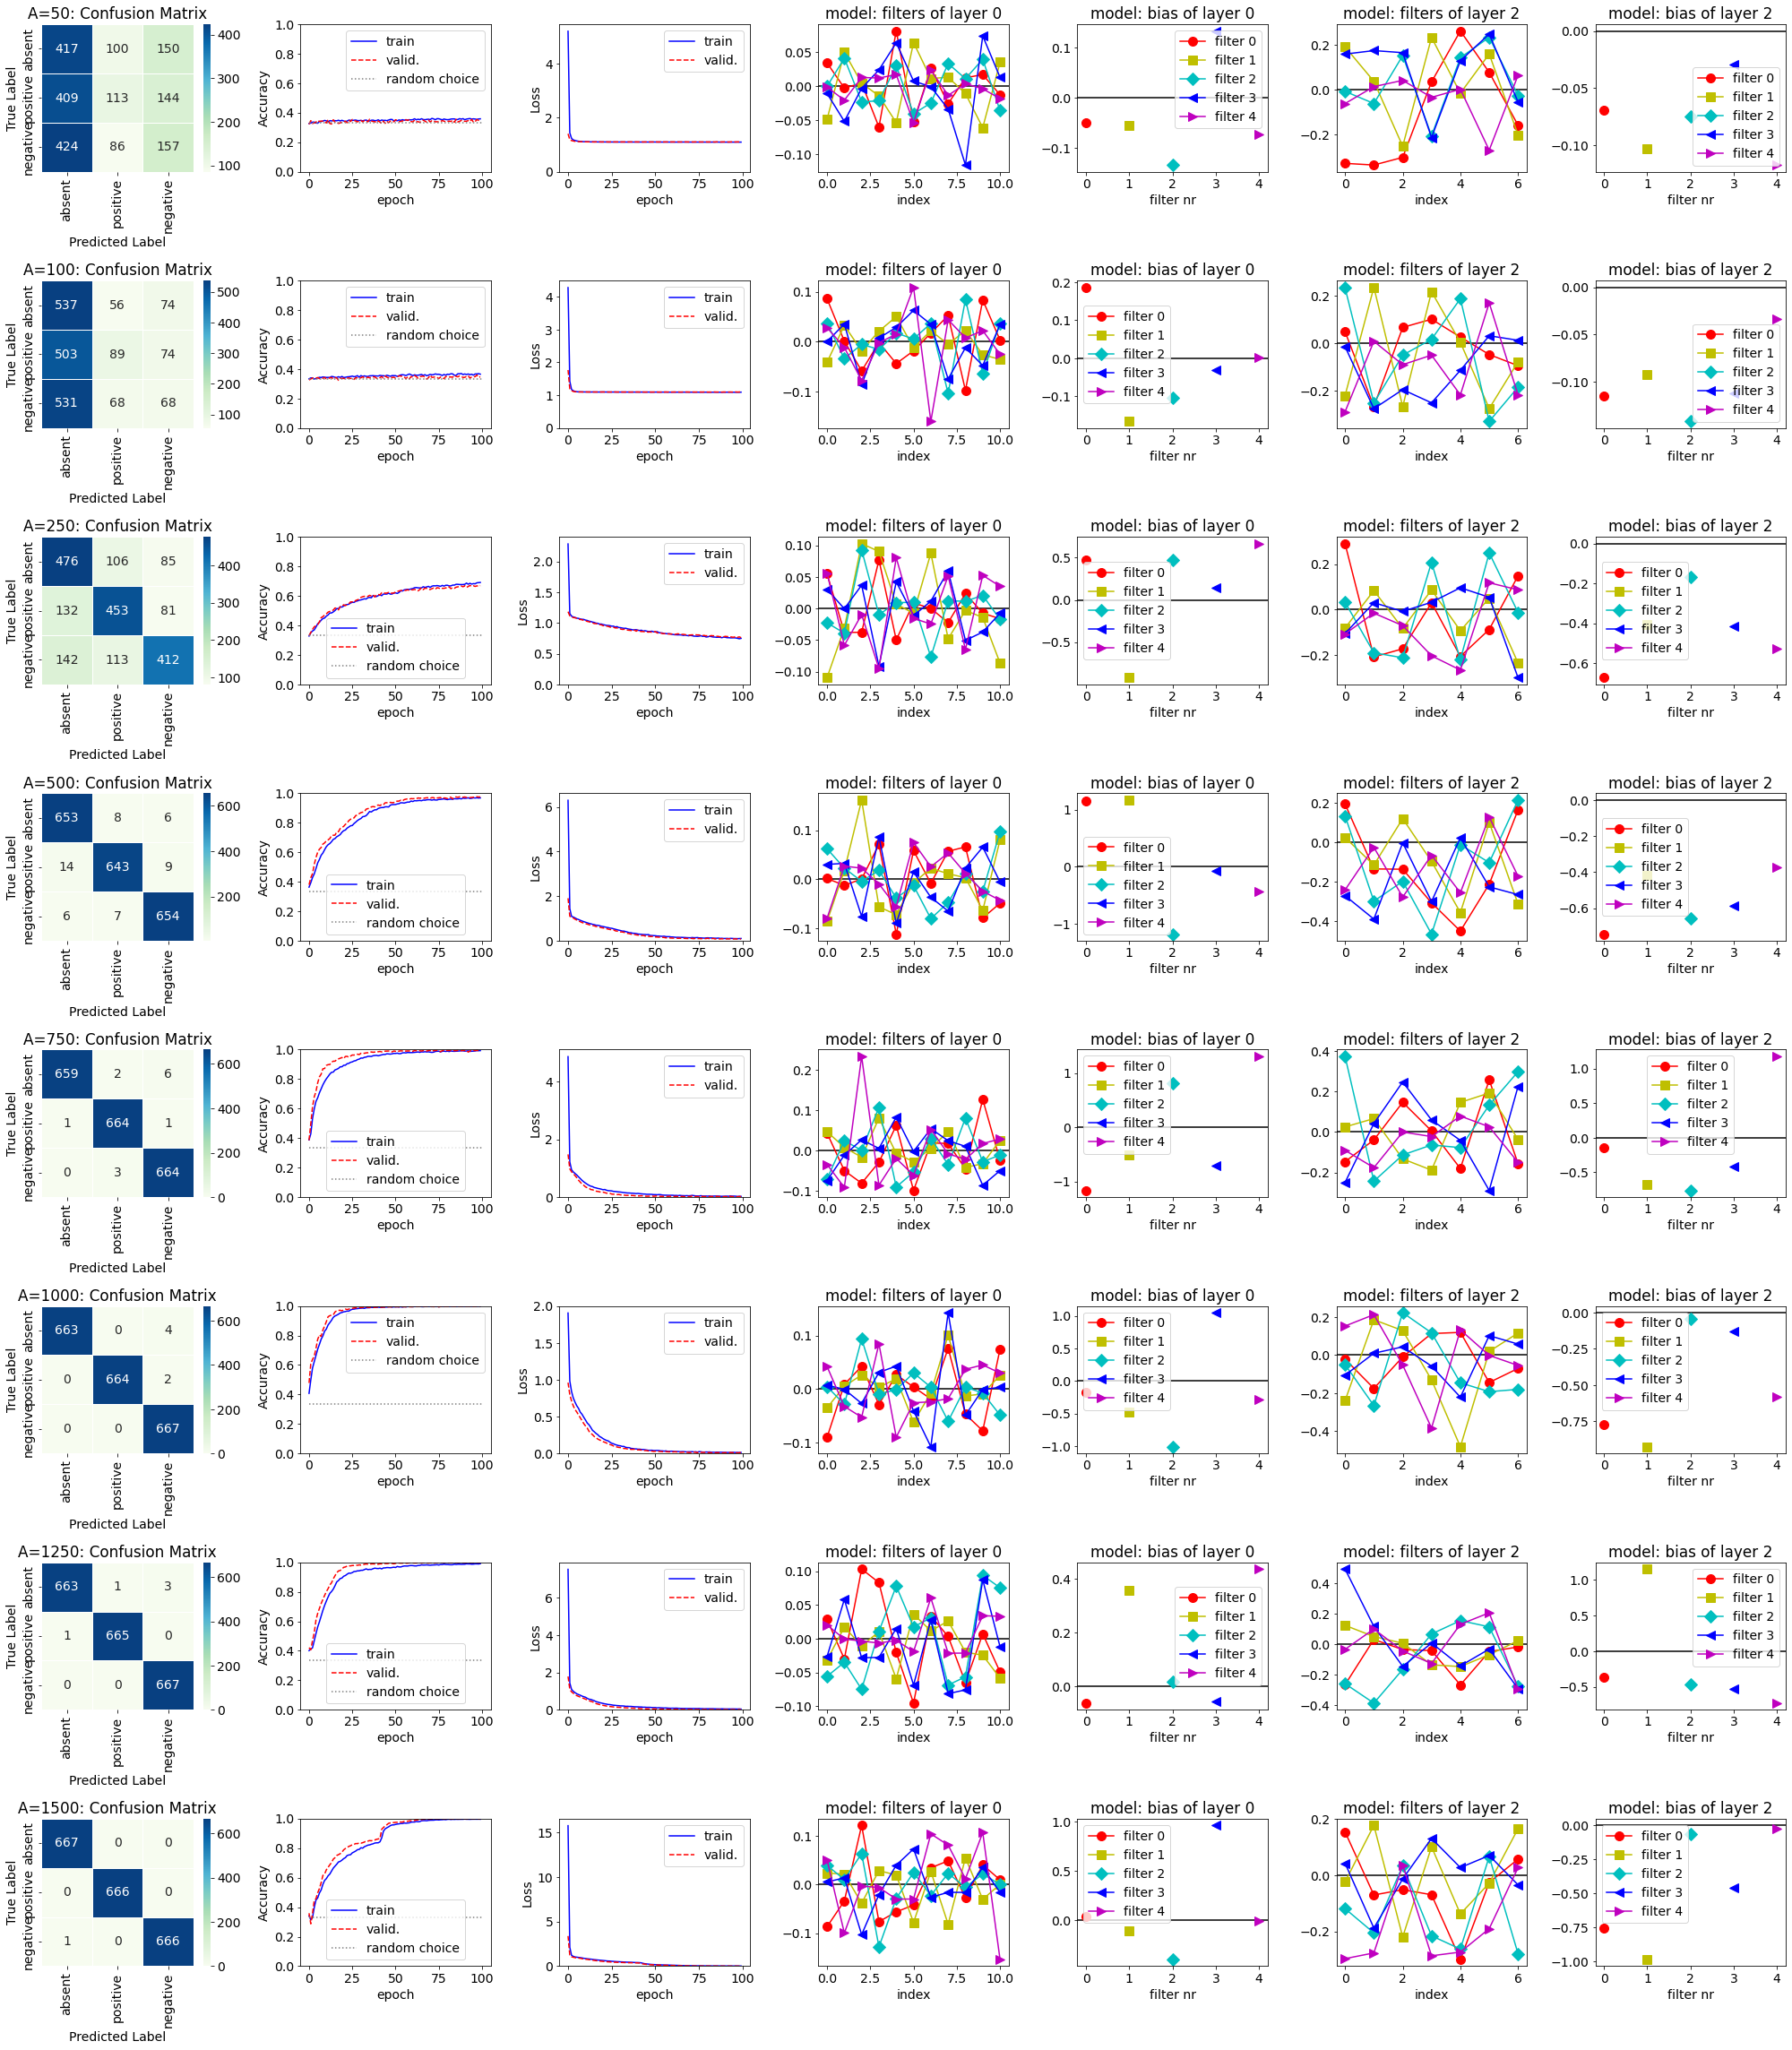

In [5]:
As = [50,100,250,500,750,1000,1250,1500]
nA = len(As)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))
BATCH_SIZE = 250
EPOCHS = 100


for A,ax in zip(As,axis):
    str0 = f'ts_L60_Z12_A{A}_DX50_bias5_N10000.dat'
    model = create_model(reg_lambda=0)
    x_train,y_train,x_val,y_val = load_data(str0)
    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 
    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val      = np.argmax(y_val,      axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)

    show_confusion_matrix(max_y_val, max_y_pred_val,f"A={A}",axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],2)
    print(f"A :{A}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()


From the above one clearly sees that the accurcay of the model increases with an increasing amplitude. This is because an increased amplitude, gives an increased signal to noise ratio. Hence the original pattern is more easily detectable in the data, and the model is capable of learning much faster. Reducing the original ratio with A = 500 by a factor of 10 yields a dramatic difference where the weights of the model is not able to converge at all.

## 3 Varying the lambda parameter

### L1 (Lasso)
It is applied a L1 regularization penalty, computed as:   loss = l1 * reduce_sum(abs(x)).
The amplitude is held fixed at A = 500.

lambda :0, Final validation accuracy 0.953000009059906  validation loss 0.1384752094745636
lambda :1e-05, Final validation accuracy 0.9455000162124634  validation loss 0.14530572295188904
lambda :0.0001, Final validation accuracy 0.9679999947547913  validation loss 0.09097340703010559
lambda :0.001, Final validation accuracy 0.9610000252723694  validation loss 0.13324223458766937
lambda :0.01, Final validation accuracy 0.9570000171661377  validation loss 0.18395055830478668
lambda :0.1, Final validation accuracy 0.9725000262260437  validation loss 0.2260528951883316
lambda :1, Final validation accuracy 0.3334999978542328  validation loss 1.1239699125289917


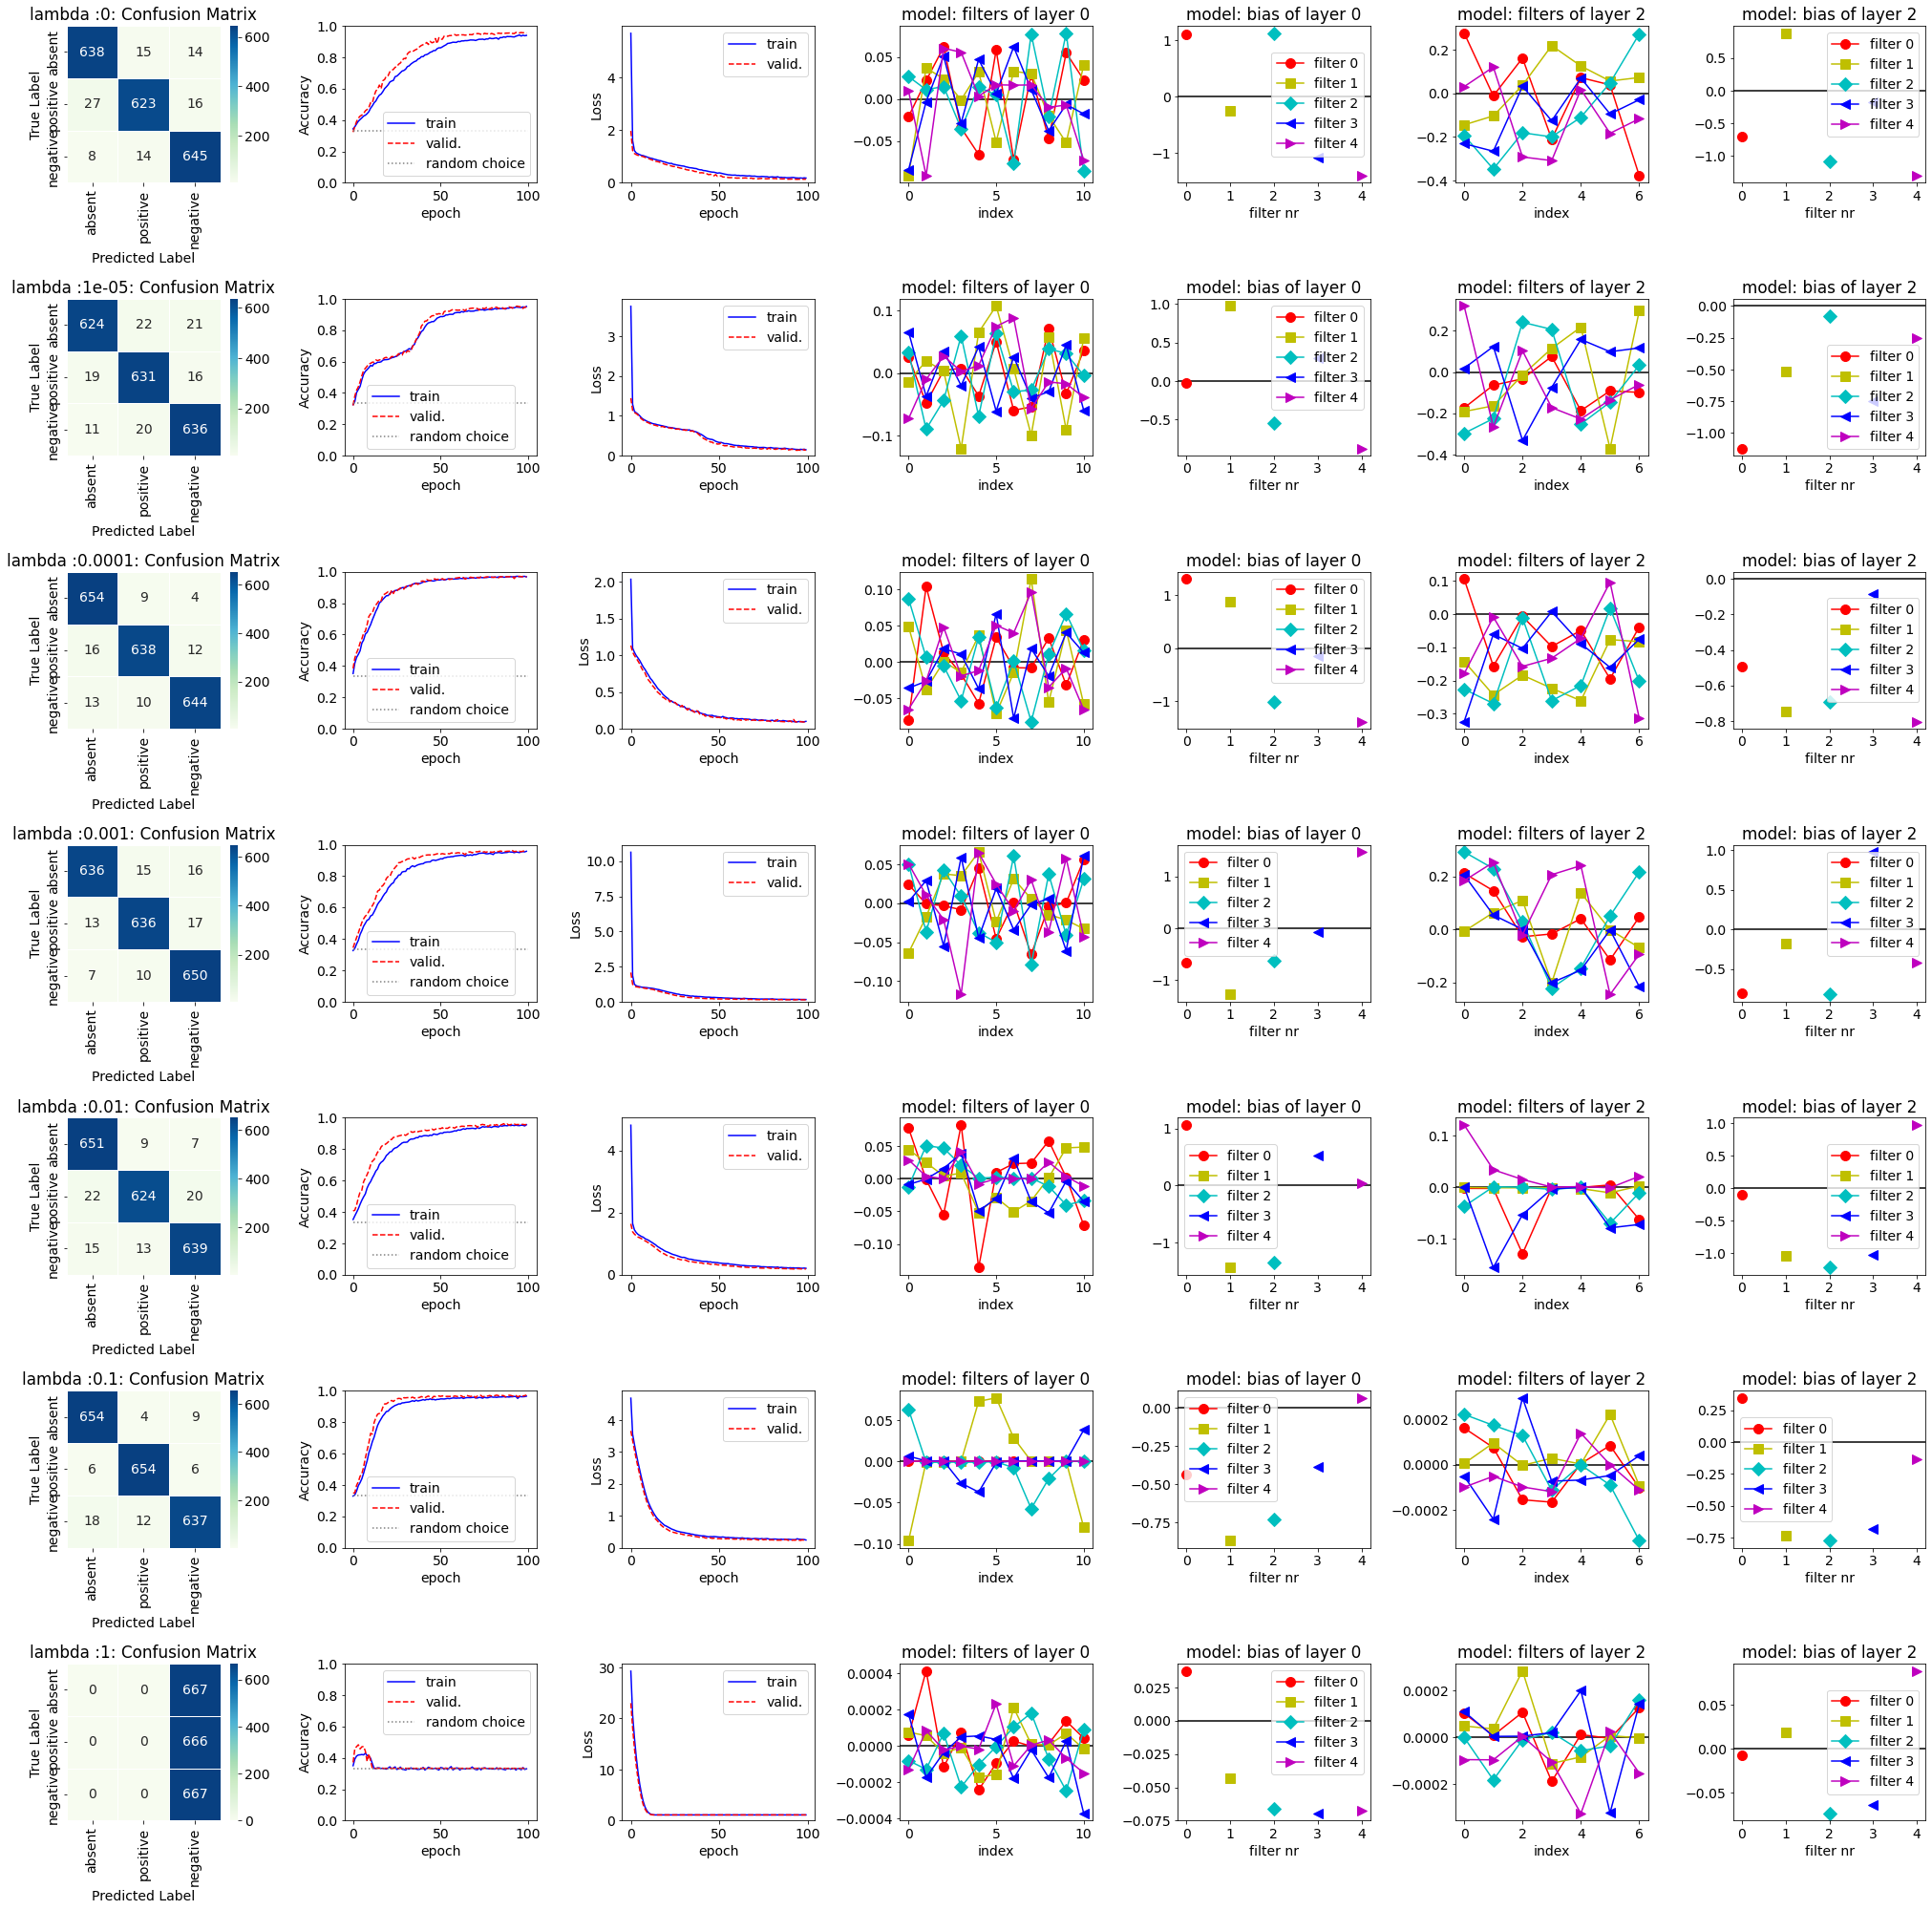

In [19]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
x_train,y_train,x_val,y_val = load_data(str0)

reg_lambdas = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1]
nA = len(reg_lambdas)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))

for reg_lambda,ax in zip(reg_lambdas,axis):
    model = create_model(reg_lambda=reg_lambda)

    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 

    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val = np.argmax(y_val, axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)

    label = f"lambda :{reg_lambda}"
    show_confusion_matrix(max_y_val, max_y_pred_val,label,axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],2)
    print(f"lambda :{reg_lambda}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()

From the plots one can tell that an optimal value of lambda in the case of Lasso regularization is in the interval $\lambda \in\left[0.0001,0.001\right]$, as this yields the best classification and lowest loss. One can also see that with an increasing value of lambda, the value of the weights of the first filters decrease due to the stronger regularization.

### L2 (Ridge)

It is applied a L2 regularization penalty, computed as: loss = l2 * reduce_sum(square(x)). The amplitude is held fixed at A = 500.

lambda :0, Final validation accuracy 0.9480000138282776  validation loss 0.13929632306098938
lambda :1e-05, Final validation accuracy 0.965499997138977  validation loss 0.11510288715362549
lambda :0.0001, Final validation accuracy 0.9605000019073486  validation loss 0.12176458537578583
lambda :0.001, Final validation accuracy 0.9605000019073486  validation loss 0.11335878074169159
lambda :0.01, Final validation accuracy 0.9545000195503235  validation loss 0.16198435425758362
lambda :0.1, Final validation accuracy 0.9635000228881836  validation loss 0.1394840031862259
lambda :1, Final validation accuracy 0.9570000171661377  validation loss 0.1695125848054886
lambda :10, Final validation accuracy 0.9190000295639038  validation loss 0.36231812834739685


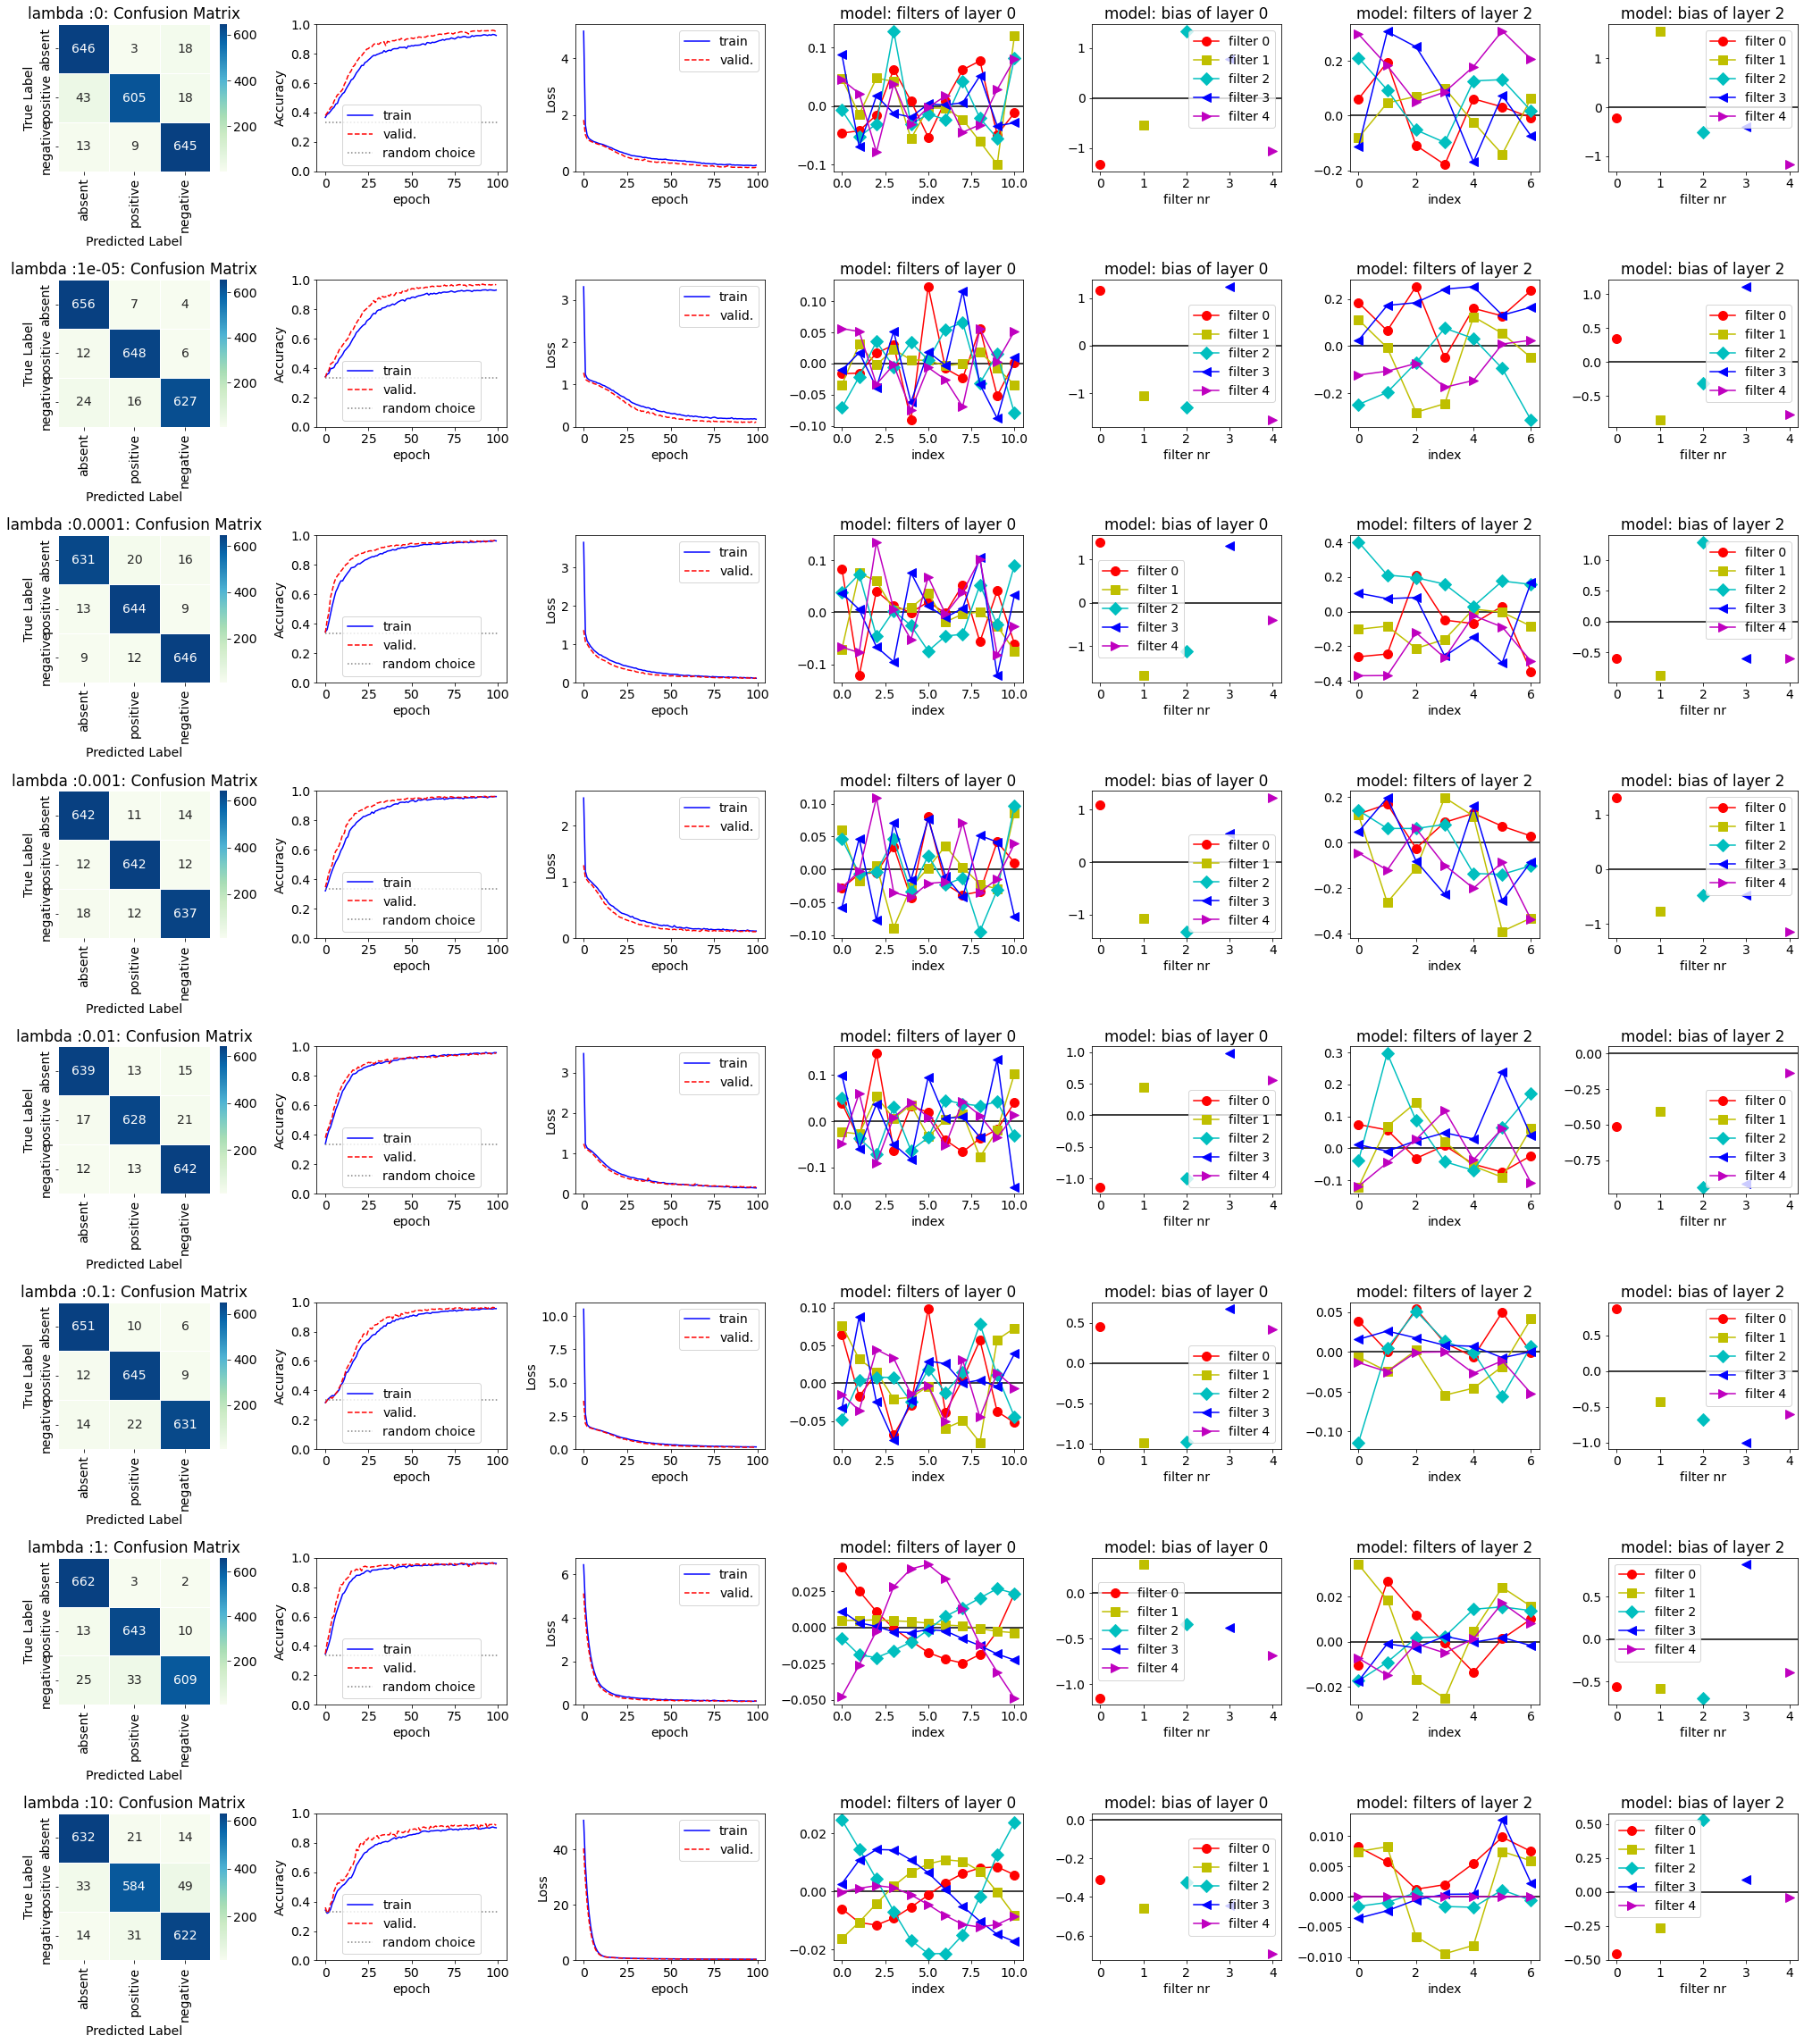

In [20]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
x_train,y_train,x_val,y_val = load_data(str0)

reg_lambdas = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
nA = len(reg_lambdas)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))

for reg_lambda,ax in zip(reg_lambdas,axis):
    model = create_model(reg_lambda=reg_lambda,reg_type=2)

    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 

    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val = np.argmax(y_val, axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)

    label = f"lambda :{reg_lambda}"
    show_confusion_matrix(max_y_val, max_y_pred_val,label,axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],2)
    print(f"lambda :{reg_lambda}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()

The results show that the optimal value of lambda for the L2-regularization is also between 0.0001 and 0.001. We see the same effect of lambda on the weights in the filters, that they decrease with increasing lambda. In the case where lambda is set to 10, the values of the weights are very low, but this also yields the lowest accuracy among the different lambda values.

### Combination of L1 and L2

lambda :0, Final validation accuracy 0.9445000290870667  validation loss 0.15753969550132751
lambda :1e-05, Final validation accuracy 0.9739999771118164  validation loss 0.08194044232368469
lambda :0.0001, Final validation accuracy 0.9670000076293945  validation loss 0.10017531365156174
lambda :0.001, Final validation accuracy 0.9559999704360962  validation loss 0.151532381772995
lambda :0.01, Final validation accuracy 0.9754999876022339  validation loss 0.12148794531822205
lambda :0.1, Final validation accuracy 0.9459999799728394  validation loss 0.3008936643600464
lambda :1, Final validation accuracy 0.3330000042915344  validation loss 1.1261770725250244
lambda :10, Final validation accuracy 0.3330000042915344  validation loss 1.3815016746520996


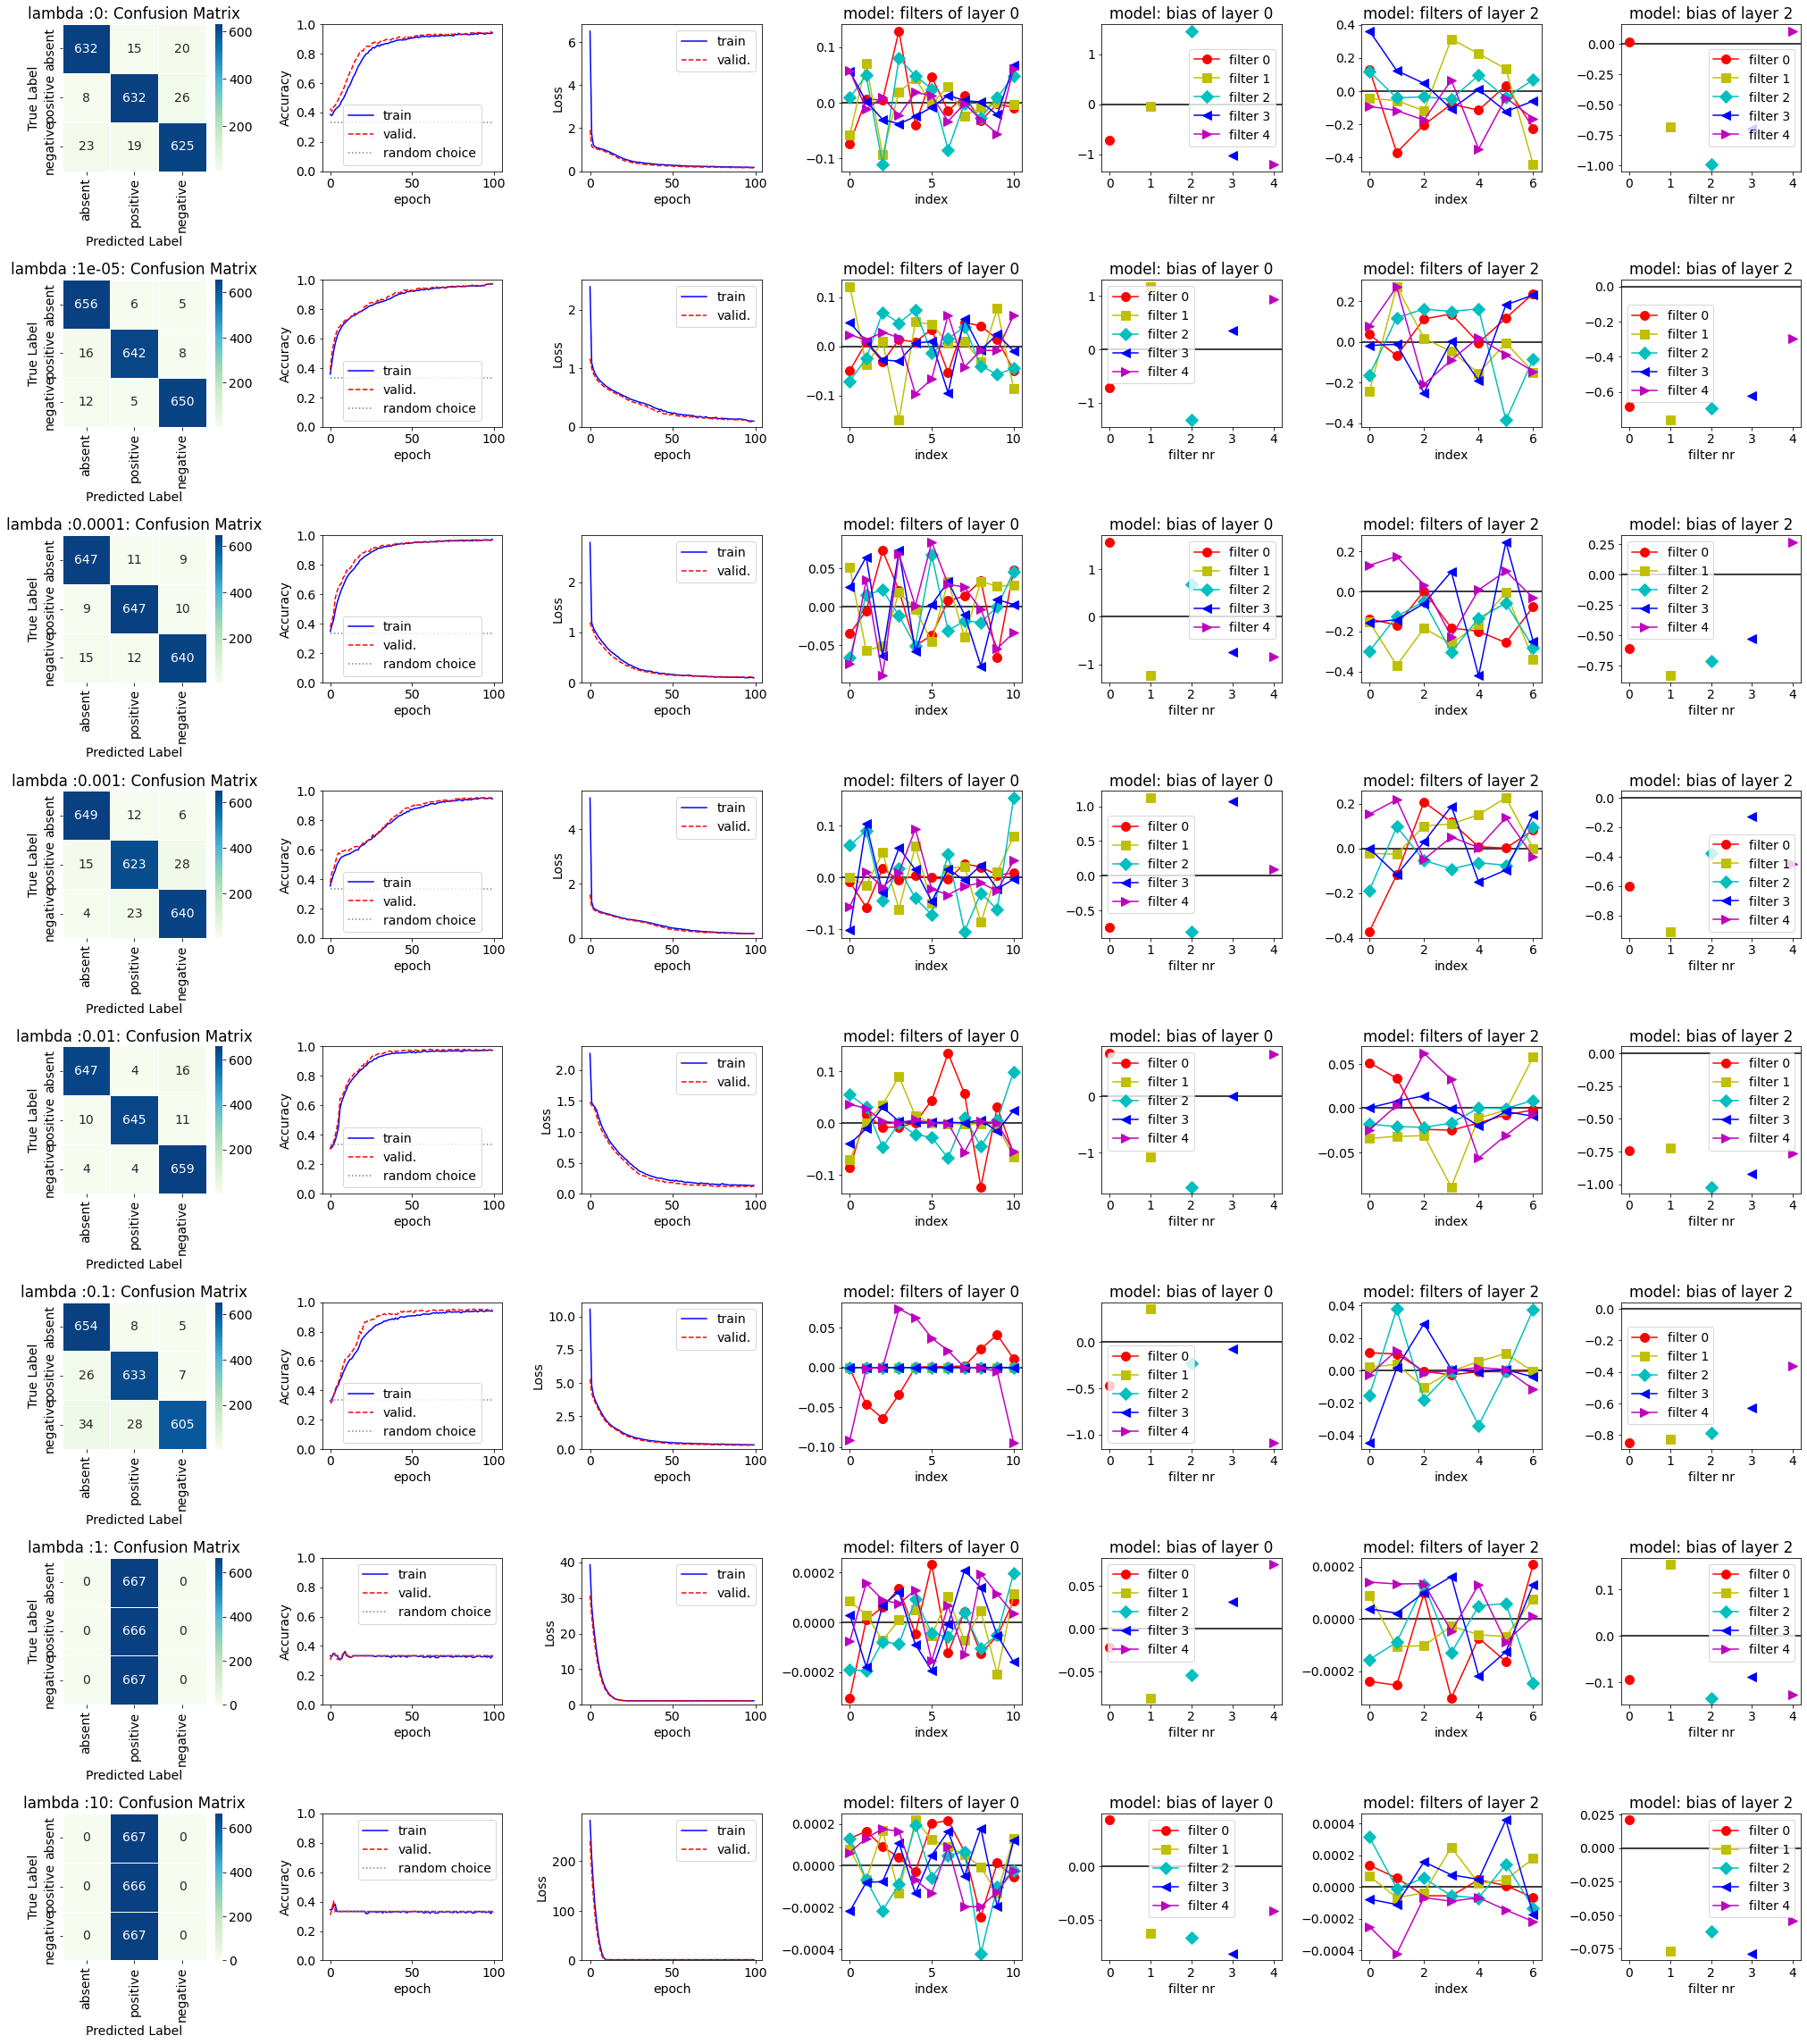

In [22]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
x_train,y_train,x_val,y_val = load_data(str0)

reg_lambdas = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
nA = len(reg_lambdas)
fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))

for reg_lambda,ax in zip(reg_lambdas,axis):
    model = create_model(reg_lambda=reg_lambda,reg_type=3)

    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=0, shuffle=True) 

    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_val = np.argmax(y_val, axis=1)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)

    label = f"lambda :{reg_lambda}"
    show_confusion_matrix(max_y_val, max_y_pred_val,label,axis=ax[0])
    Show_history(fit,ax[1],ax[2])
    Show_weights(model,ax[3],ax[4],0)
    Show_weights(model,ax[5],ax[6],2)
    print(f"lambda :{reg_lambda}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])

plt.tight_layout()
plt.show()

The combination of L1 and L2 regularization also performs best with a lambda between 0.0001 and 0.001.

## 4. Comparison between different arcitectures

Using the best model made laste year.

In [50]:
def create_best_model(reg_type=3,reg_lambda=0.0001):
    if reg_type == 1:
        reg = tf.keras.regularizers.l1(reg_lambda)
    
    elif reg_type == 2:
        reg = tf.keras.regularizers.l2(reg_lambda) ## raised to 0.2
        
    elif reg_type == 3:
        reg = tf.keras.regularizers.l1_l2(reg_lambda, reg_lambda)
        

    #ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                           # seed=None)
    ini = tf.keras.initializers.GlorotNormal()
    
    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=3, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    model.add(Conv1D(filters=8, kernel_size=9, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    model.add(Conv1D(filters=4, kernel_size=3, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    model.add(GlobalMaxPooling1D( ))
    model.add(Flatten())
    model.add(Dense(3, activation='relu'))

    opt = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=opt,metrics=['accuracy'])
    
    return model
    

In [28]:
model_best = create_best_model(reg_lambda = 0)
model_best.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_173 (Conv1D)          (None, 58, 6)             24        
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 50, 8)             440       
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 48, 4)             100       
_________________________________________________________________
global_max_pooling1d (Global (None, 4)                 0         
_________________________________________________________________
flatten_84 (Flatten)         (None, 4)                 0         
_________________________________________________________________
dense_168 (Dense)            (None, 3)                 15        
Total params: 579
Trainable params: 579
Non-trainable params: 0
_______________________________________________________

Epoch 1/100
32/32 - 0s - loss: 5.0244 - accuracy: 0.4026 - val_loss: 1.2505 - val_accuracy: 0.3465
Epoch 2/100
32/32 - 0s - loss: 1.0684 - accuracy: 0.3525 - val_loss: 1.0028 - val_accuracy: 0.3635
Epoch 3/100
32/32 - 0s - loss: 0.9491 - accuracy: 0.4268 - val_loss: 0.8815 - val_accuracy: 0.5020
Epoch 4/100
32/32 - 0s - loss: 0.7452 - accuracy: 0.5443 - val_loss: 0.5484 - val_accuracy: 0.6410
Epoch 5/100
32/32 - 0s - loss: 0.5312 - accuracy: 0.6420 - val_loss: 0.4971 - val_accuracy: 0.6540
Epoch 6/100
32/32 - 0s - loss: nan - accuracy: 0.3532 - val_loss: nan - val_accuracy: 0.3335


ValueError: Axis limits cannot be NaN or Inf

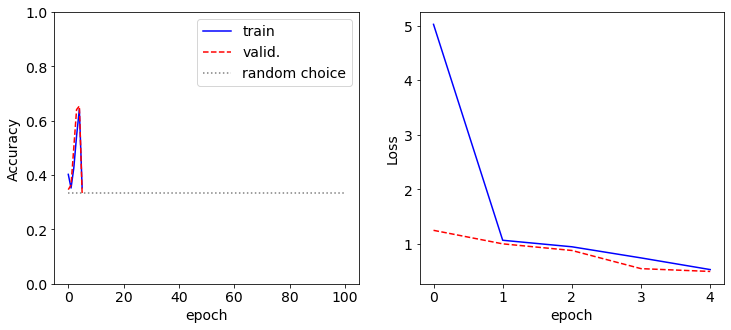

In [66]:
#Lets redo the run with varying amplitude
#As = [50,100,250,500,750,1000,1250,1500]
#As = [500]
#nA = len(As)
#fig,axis = plt.subplots(nA,7,figsize = (28,4*nA))
BATCH_SIZE = 250
EPOCHS = 100

streng = 'ts_L60_Z12_A1250_DX50_bias5_N10000.dat'

model_best = create_best_model(reg_lambda = 0)
x_train,y_train,x_val,y_val = load_data(streng)
es = EarlyStopping(monitor='val_loss', mode='min')
fit_best = model_best.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_data=(x_val, y_val), verbose=2, shuffle=True, callbacks = [es]) 
y_pred_val = model_best.predict(x_val)
    # Take the class with the highest probability from the val predictions
max_y_val      = np.argmax(y_val,      axis=1)
max_y_pred_val = np.argmax(y_pred_val, axis=1)

#show_confusion_matrix(max_y_val, max_y_pred_val,f"A={A}",axis=ax[0])
Show_history_single(fit_best)
#Show_weights(model,ax[3],ax[4],0)
#Show_weights(model,ax[5],ax[6],2)
#print(f"A :{A}, Final validation accuracy",fit.history["val_accuracy"][-1]," validation loss",fit.history["val_loss"][-1])
